## For assigned hyperparameter "activation function of the fully connected layers"

5 possible values for this hyperparameter: relu, sigmoid, tanh, linear, leaky relu

## approach:
1) checking which activation functions are available for dense layer activation function -> https://keras.io/api/layers/activations/#selu-function
2) not including soft-x function as they are mostly used in output layers
3) this guide (https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6) explains the mathematical function behind some functions, their problems and an example
4) https://towardsdatascience.com/if-rectified-linear-units-are-linear-how-do-they-add-nonlinearity-40247d3e4792
5) https://www.v7labs.com/blog/neural-networks-activation-functions

## notes:
relu: does not have a maximum therefore helps with gradient descent; very fast to compute compared to exponential functions such as tanh and sigmoid; has the 'dying relu' problem where neurons are dead due to weight tweaking leading to negative numbers (effectivly only outputing 0)

sigmoid: computationally intense; input close to 0 or 1 results in almost no gradient to propagate back through the network; not zero centered

tanh: zero centered; similar to sigmoid and works with gradient descent; tends to make output of each layer around zero therfore converges fast; vanishing gradient similar to sigmoid; computational intense

linear: behaves like relu for positive numbers but negative numbers are not zero; can not solve non-linear problems; requires more layers than non-linear functions; does not change input therefore not backpropagation

leaky relu: has the same advantages as relu but has some backpropagation for negative numbers therefore solves the 'dying relu' problem; due to small negative values learning is time-consuming;

## assumptions:
training the neural network with linear and relu activation functions will be faster compared to leaky relu and especially faster than sigmoid and tanh. however the linear activation function does not make backpropagations and can not solve non-linear solutions. therefore it will be best to choose relu or exponential functions. exponential functions have the advantage that they converge faster and work with gradient descent. therefore exponential function will require less epochs than relu or linear.

In [10]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
# not working for me
#from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [11]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'_dataset/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [12]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [13]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    #for filename in tqdm(os.listdir(condition)):
    for filename in os.listdir(f"_dataset/{condition}"):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'./_dataset/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [15]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


# 1) RELU

In [16]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## now, we can train the model using the fit() function
## this will take a while

In [17]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 5s 59ms/step - loss: 1.0719 - accuracy: 0.4043 - val_loss: 1.0393 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 3s 44ms/step - loss: 1.0449 - accuracy: 0.4609 - val_loss: 1.1710 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 3s 44ms/step - loss: 1.0238 - accuracy: 0.4883 - val_loss: 0.8888 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 3s 43ms/step - loss: 0.8090 - accuracy: 0.6484 - val_loss: 0.7769 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 3s 46ms/step - loss: 0.6451 - accuracy: 0.7441 - val_loss: 0.6686 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 4s 57ms/step - loss: 0.4664 - accuracy: 0.8066 - val_loss: 0.5146 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 4s 65ms/step - loss: 0.3

In [18]:
# let's have a look at our model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_1 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_3 (Conv2D)           (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_3 (MaxPooling  (8, 16, 16, 64)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_4 (MaxPooling  (8, 6, 6, 32)           

## Plot accuracy and loss of the training process

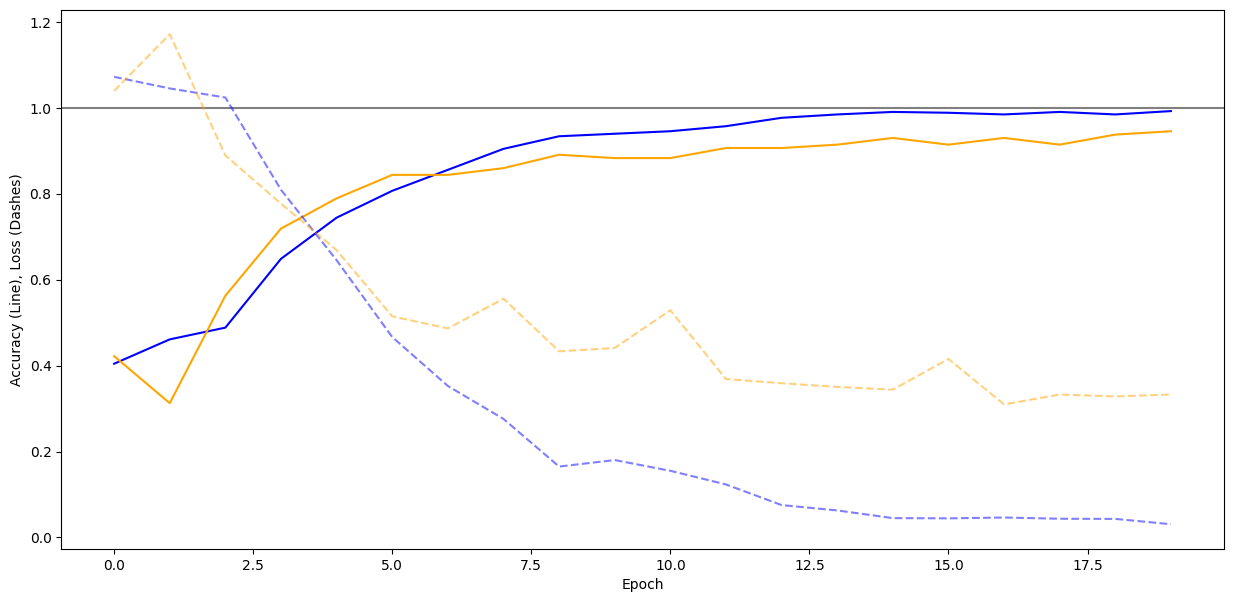

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## visualize classification results with a confusion matrix

4/4 [==============================] - 0s 38ms/step
before [[5.38733875e-05 9.99943435e-01 2.65344352e-06]
 [9.99999940e-01 4.72780357e-08 2.84062782e-08]
 [9.99999821e-01 1.74891298e-07 8.80252315e-09]
 [5.08328412e-06 9.99994457e-01 3.05843457e-07]
 [7.23877165e-05 9.99925673e-01 1.95664484e-06]
 [9.98655975e-01 4.12560272e-04 9.31509887e-04]
 [9.99118090e-01 3.51232680e-04 5.30558231e-04]
 [8.74921322e-01 1.24300994e-01 7.77626177e-04]
 [9.99979794e-01 1.55833659e-05 4.56920952e-06]
 [5.95139805e-03 9.93493497e-01 5.55088744e-04]
 [4.41391282e-02 2.04023093e-01 7.51837730e-01]
 [9.99999821e-01 9.69865752e-08 2.85170181e-08]
 [9.44163639e-06 9.99989450e-01 1.08040103e-06]
 [6.06744106e-05 9.99048769e-01 8.90575699e-04]
 [9.68939483e-01 3.10211815e-02 3.93787122e-05]
 [3.68183814e-02 9.37849656e-03 9.53803122e-01]
 [1.19056662e-04 1.06548505e-04 9.99774456e-01]
 [1.79171977e-07 7.43736155e-06 9.99992311e-01]
 [9.99999940e-01 2.52560568e-08 1.68269443e-09]
 [1.01433238e-02 3.54983076e-

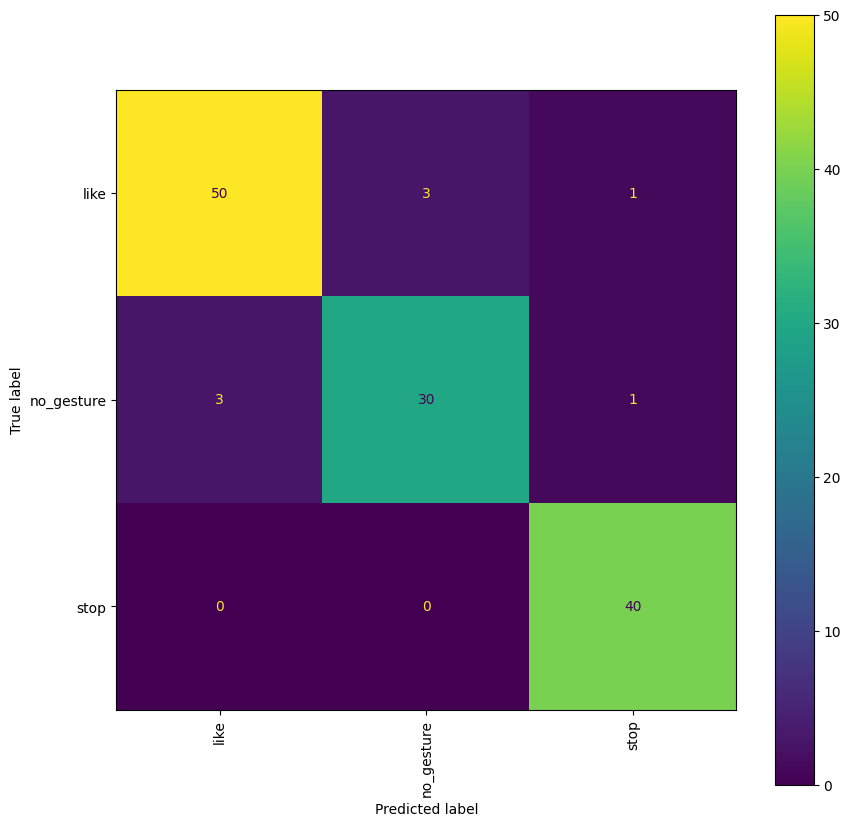

In [39]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# 2) sigmoid

In [40]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [41]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 4s 50ms/step - loss: 1.0701 - accuracy: 0.3770 - val_loss: 1.0408 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 3s 51ms/step - loss: 1.0159 - accuracy: 0.4727 - val_loss: 1.1460 - val_accuracy: 0.3359 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 3s 49ms/step - loss: 0.9412 - accuracy: 0.5391 - val_loss: 0.8814 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 3s 50ms/step - loss: 0.6788 - accuracy: 0.7070 - val_loss: 0.7592 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 3s 54ms/step - loss: 0.5293 - accuracy: 0.7910 - val_loss: 0.5534 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 4s 58ms/step - loss: 0.3382 - accuracy: 0.8730 - val_loss: 0.4512 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 4s 62ms/step - loss: 0.2

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_4 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_12 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_12 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_13 (MaxPoolin  (8, 6, 6, 32)           

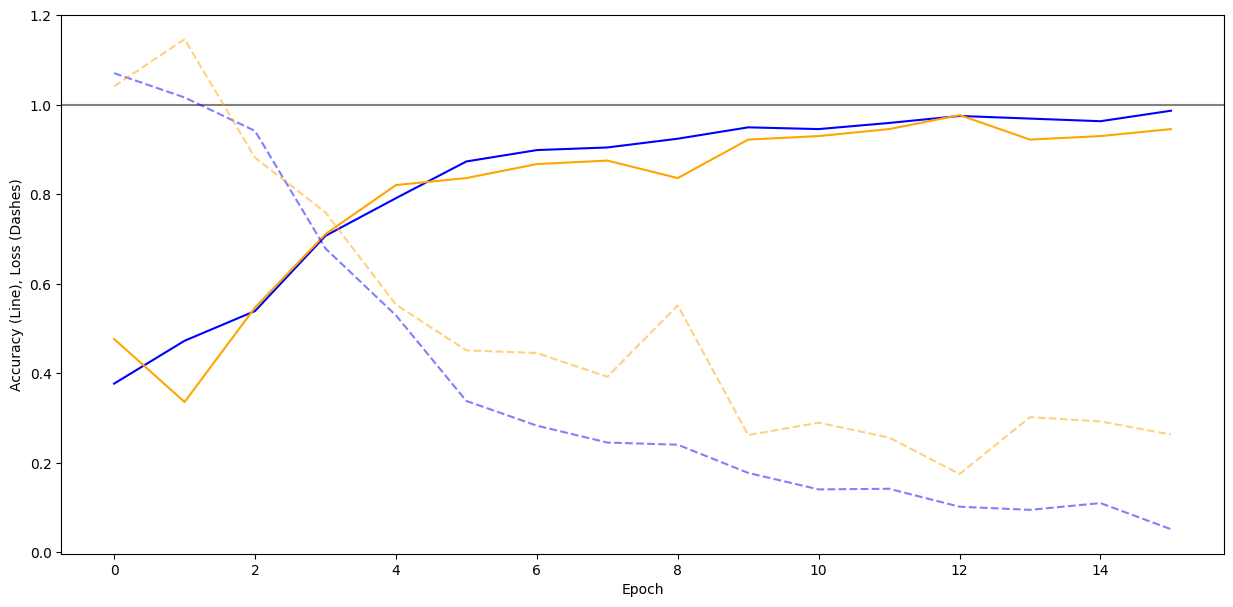

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 39ms/step
before [[4.12247937e-06 9.99982417e-01 1.33208823e-05]
 [9.99999702e-01 2.49632507e-07 1.08553460e-08]
 [9.99999583e-01 3.27864200e-07 4.73453832e-10]
 [2.85806582e-05 9.99966204e-01 5.11447479e-06]
 [5.17473818e-05 9.99900877e-01 4.73600667e-05]
 [9.99143720e-01 3.97097931e-04 4.59163566e-04]
 [9.99621093e-01 3.21620435e-04 5.72734280e-05]
 [9.85424638e-01 1.45628741e-02 1.25883889e-05]
 [9.67517197e-01 3.24000418e-02 8.26644609e-05]
 [4.95838700e-03 9.90933955e-01 4.10756702e-03]
 [1.75492768e-03 4.47737090e-02 9.53471422e-01]
 [9.99996483e-01 3.48926164e-06 5.96953931e-10]
 [3.01124820e-10 9.99999940e-01 1.50968802e-08]
 [2.55365262e-06 9.98940170e-01 1.05735089e-03]
 [7.42097318e-01 2.57828653e-01 7.39565803e-05]
 [8.24050687e-04 5.91966207e-04 9.98584032e-01]
 [3.70062073e-04 2.39068046e-04 9.99390721e-01]
 [3.15284012e-07 2.84453392e-07 9.99999344e-01]
 [9.99999940e-01 5.70559422e-08 6.10375778e-11]
 [2.38255202e-03 6.02943450e-

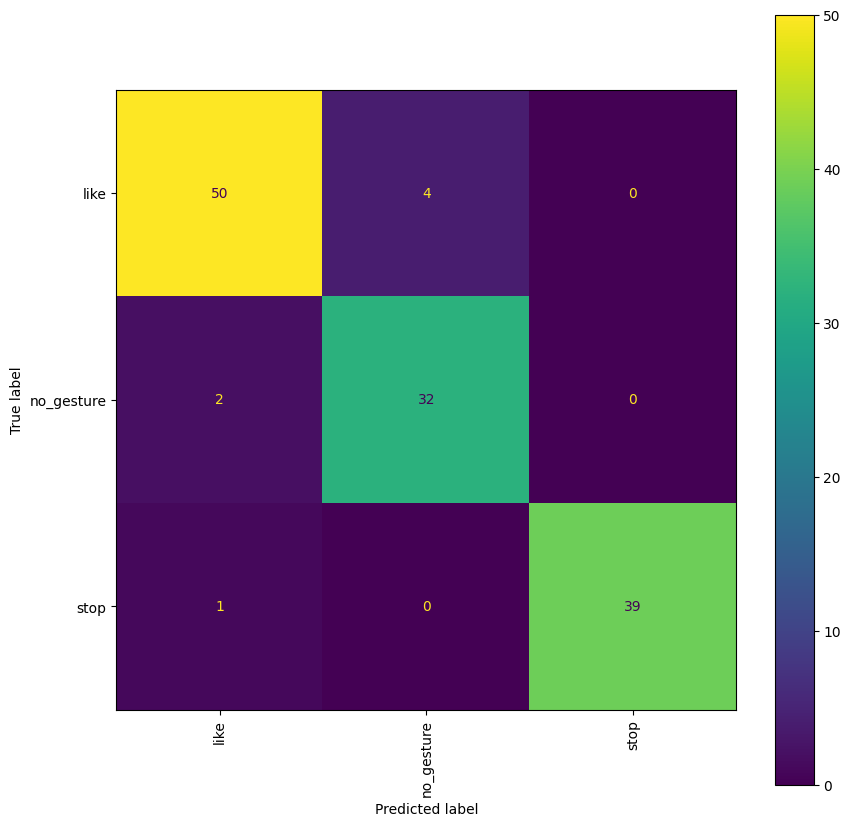

In [44]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# 3) tanh

In [45]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'tanh'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [46]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 5s 55ms/step - loss: 1.0575 - accuracy: 0.4219 - val_loss: 0.9826 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 3s 53ms/step - loss: 0.7765 - accuracy: 0.6641 - val_loss: 0.6712 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 4s 55ms/step - loss: 0.4434 - accuracy: 0.8262 - val_loss: 0.5771 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 4s 56ms/step - loss: 0.3254 - accuracy: 0.8691 - val_loss: 0.3766 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 3s 54ms/step - loss: 0.2928 - accuracy: 0.8965 - val_loss: 0.3308 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 4s 58ms/step - loss: 0.1983 - accuracy: 0.9258 - val_loss: 0.3379 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 3s 53ms/step - loss: 0.1

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_5 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_15 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_15 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_16 (MaxPoolin  (8, 6, 6, 32)           

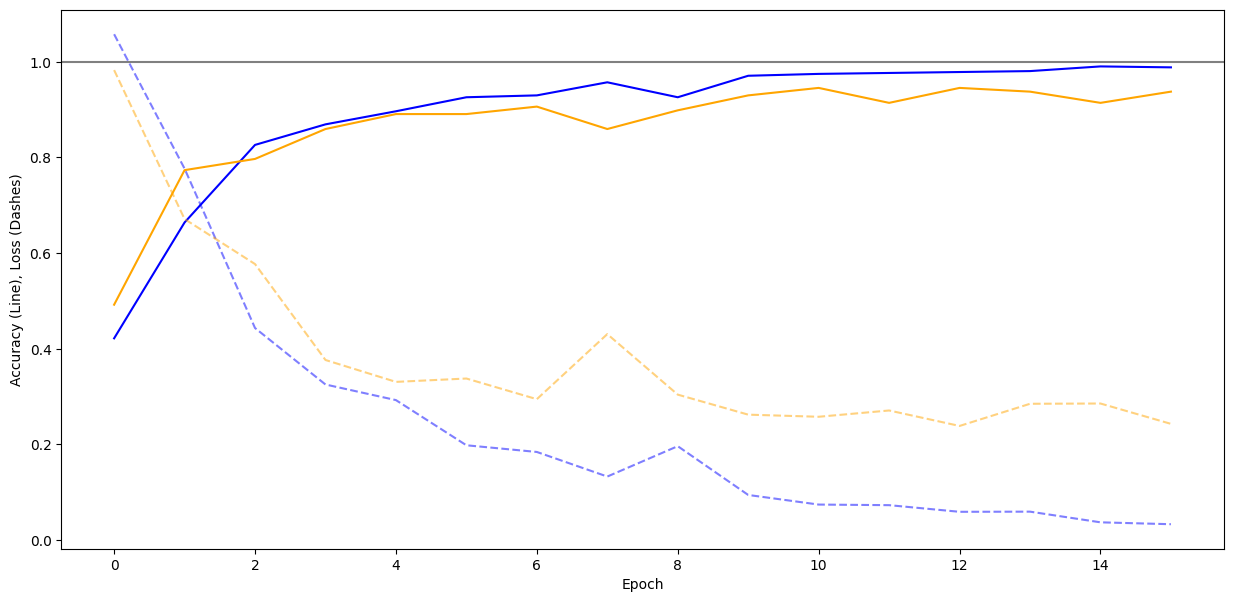

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 41ms/step
before [[5.99295599e-04 9.92682934e-01 6.71771262e-03]
 [9.99239564e-01 2.52584054e-04 5.07881225e-04]
 [9.99187410e-01 2.41023212e-04 5.71671233e-04]
 [2.96554761e-04 9.99600470e-01 1.02909005e-04]
 [1.35970200e-04 9.99770641e-01 9.34430282e-05]
 [9.91370618e-01 1.00101961e-03 7.62826158e-03]
 [9.88284290e-01 4.05118451e-04 1.13104973e-02]
 [9.44545150e-01 5.37121780e-02 1.74265145e-03]
 [9.87604022e-01 6.66907104e-03 5.72688412e-03]
 [2.14075833e-03 9.97726381e-01 1.32797504e-04]
 [1.40972044e-02 3.90431732e-02 9.46859598e-01]
 [9.98835862e-01 6.92747475e-04 4.71442851e-04]
 [1.11718786e-04 9.99046504e-01 8.41736852e-04]
 [3.91609210e-04 9.98601675e-01 1.00659067e-03]
 [9.95024502e-01 4.07255441e-03 9.02866712e-04]
 [2.56499410e-01 3.18917516e-03 7.40311325e-01]
 [6.81179925e-04 1.39504511e-04 9.99179304e-01]
 [8.65113689e-04 3.15901911e-04 9.98818934e-01]
 [9.98975754e-01 6.33844989e-04 3.90375819e-04]
 [1.65706361e-03 8.80748790e-

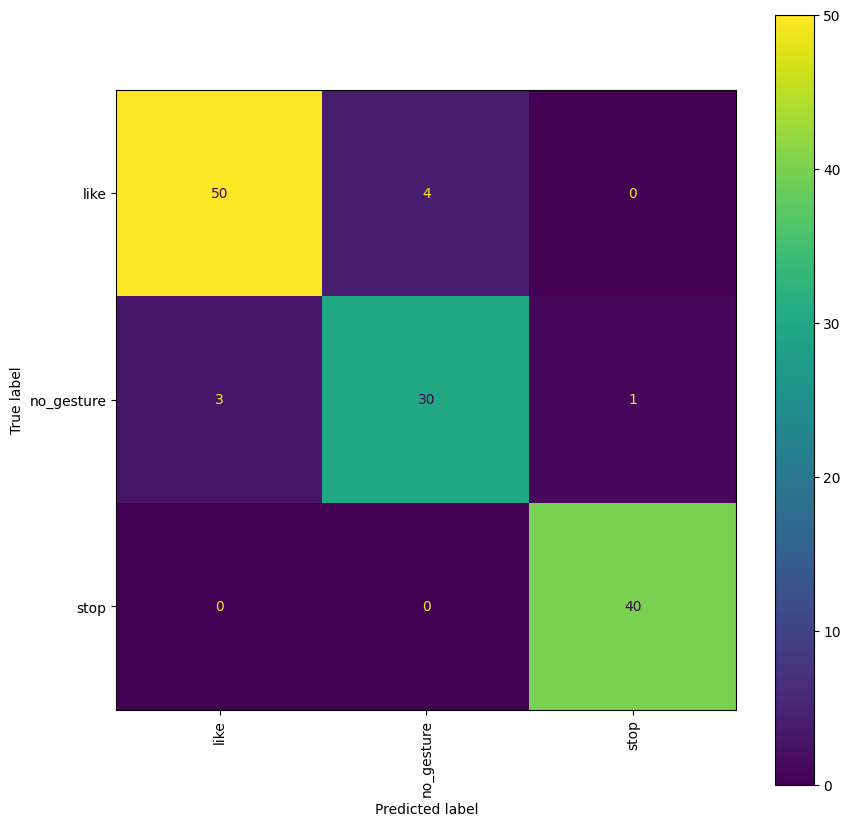

In [49]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# 4) linear


In [50]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'linear'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [51]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 5s 52ms/step - loss: 1.0840 - accuracy: 0.4453 - val_loss: 1.0871 - val_accuracy: 0.3203 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 4s 60ms/step - loss: 0.8757 - accuracy: 0.5859 - val_loss: 0.7331 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 4s 59ms/step - loss: 0.5732 - accuracy: 0.7754 - val_loss: 0.4970 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 4s 62ms/step - loss: 0.4297 - accuracy: 0.8340 - val_loss: 0.5030 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 4s 58ms/step - loss: 0.3535 - accuracy: 0.8691 - val_loss: 0.4264 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 4s 56ms/step - loss: 0.2348 - accuracy: 0.9043 - val_loss: 0.4383 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 4s 64ms/step - loss: 0.2

In [52]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_6 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_18 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_18 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_19 (MaxPoolin  (8, 6, 6, 32)           

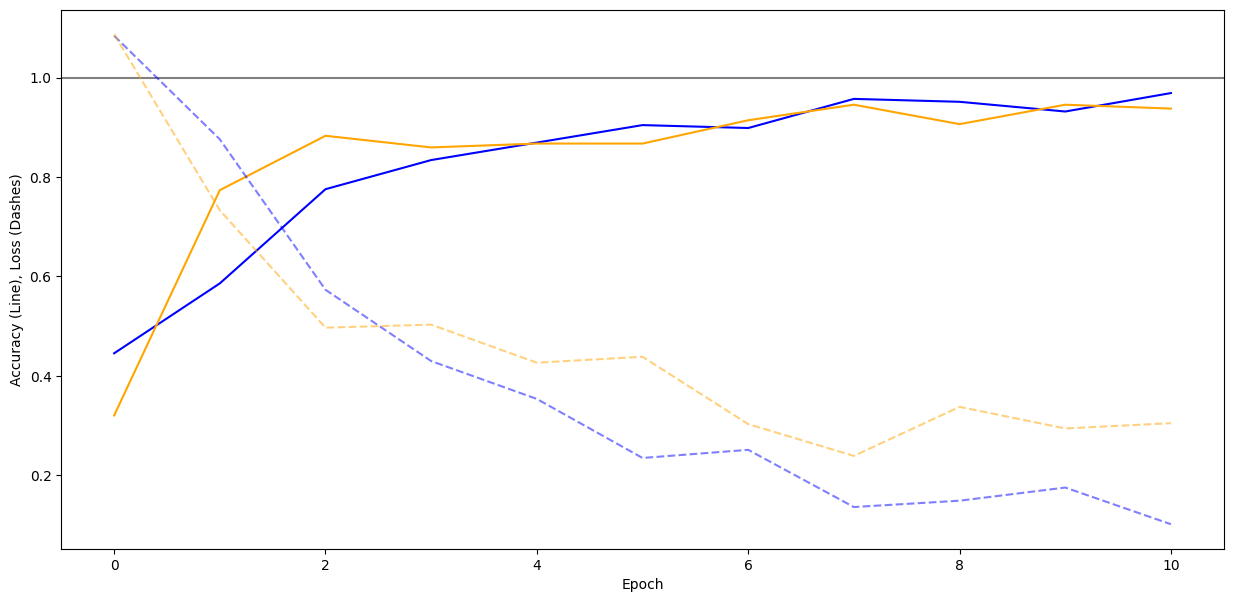

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 41ms/step
before [[6.32966694e-05 9.96663988e-01 3.27266008e-03]
 [9.99999940e-01 1.57263417e-13 1.20986119e-08]
 [9.99999940e-01 6.27176132e-12 6.69282352e-10]
 [1.10578558e-05 9.99951541e-01 3.72992326e-05]
 [7.00888631e-05 9.99898612e-01 3.12587508e-05]
 [9.91316497e-01 1.00400466e-04 8.58298317e-03]
 [9.52174723e-01 2.60841739e-06 4.78226766e-02]
 [9.96290743e-01 3.67945852e-03 2.97795195e-05]
 [9.98891711e-01 1.39938376e-04 9.68442007e-04]
 [3.53717152e-03 9.95114267e-01 1.34842028e-03]
 [1.14545925e-02 1.67430881e-02 9.71802235e-01]
 [9.99999940e-01 7.47178375e-10 1.81800175e-08]
 [5.37780431e-10 9.99999940e-01 3.00378815e-08]
 [3.44316395e-05 9.58627999e-01 4.13377173e-02]
 [8.92580032e-01 8.80515054e-02 1.93684176e-02]
 [3.76377883e-03 1.26012616e-04 9.96110201e-01]
 [3.34417517e-03 1.28046258e-05 9.96643066e-01]
 [1.86885627e-05 2.92957139e-07 9.99980986e-01]
 [9.99999940e-01 1.39855599e-10 1.28399430e-10]
 [1.32717313e-02 1.50673164e-

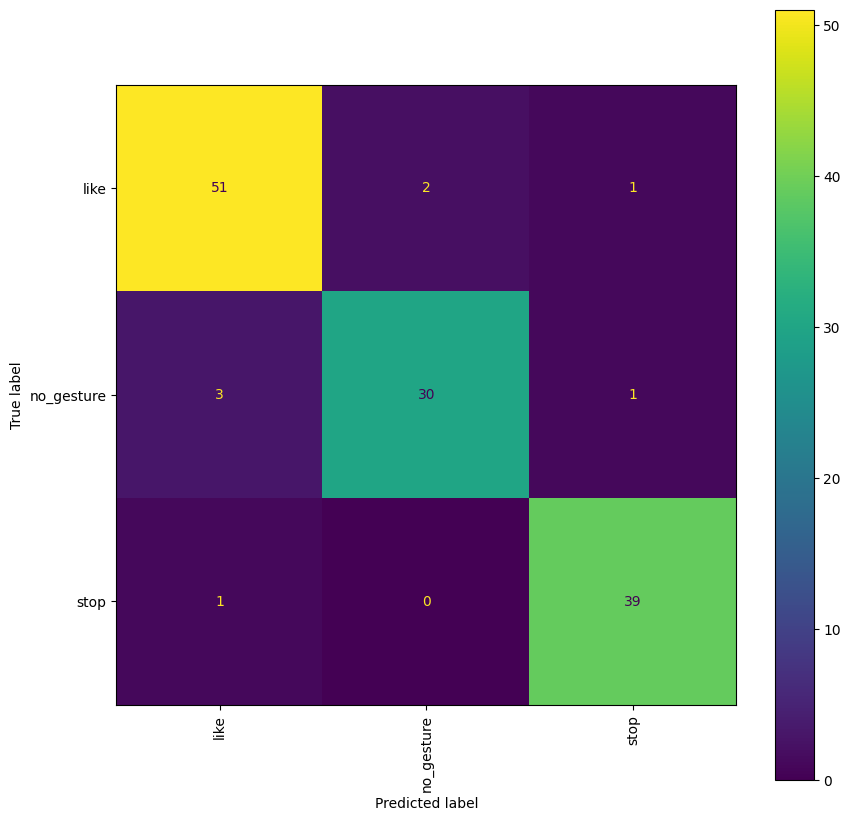

In [54]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# 5) leaky relu

In [55]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'LeakyReLU'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [56]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 5s 55ms/step - loss: 1.0527 - accuracy: 0.4375 - val_loss: 1.0206 - val_accuracy: 0.4453 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 4s 55ms/step - loss: 0.9876 - accuracy: 0.4863 - val_loss: 0.9214 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 4s 58ms/step - loss: 0.7698 - accuracy: 0.6855 - val_loss: 0.6096 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 4s 57ms/step - loss: 0.4497 - accuracy: 0.8398 - val_loss: 0.6403 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 4s 60ms/step - loss: 0.2960 - accuracy: 0.8848 - val_loss: 0.4143 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 4s 59ms/step - loss: 0.2827 - accuracy: 0.9121 - val_loss: 0.3550 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 4s 58ms/step - loss: 0.1

In [57]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_7 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_7 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_21 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_21 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_22 (MaxPoolin  (8, 6, 6, 32)           

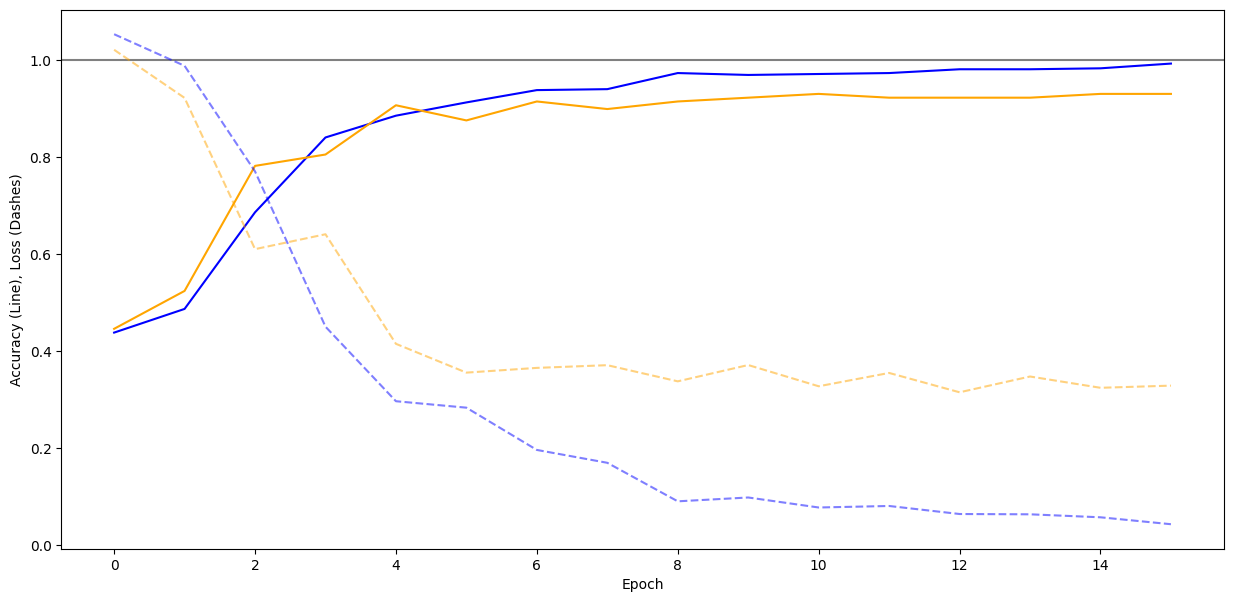

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 43ms/step
before [[1.82626827e-03 9.92513537e-01 5.66027034e-03]
 [9.99999940e-01 5.37033924e-11 2.82093932e-10]
 [9.99999940e-01 3.69360009e-09 5.33912740e-11]
 [3.29747854e-05 9.99957621e-01 9.28659756e-06]
 [2.37362110e-05 9.99970615e-01 5.55819224e-06]
 [9.99715567e-01 1.54420457e-04 1.30040251e-04]
 [9.97559965e-01 5.31501937e-05 2.38676090e-03]
 [9.88613725e-01 1.13518033e-02 3.43956599e-05]
 [9.99838352e-01 1.44019759e-05 1.47301922e-04]
 [7.46161072e-03 9.90420282e-01 2.11816910e-03]
 [2.40687318e-02 6.03957295e-01 3.71974021e-01]
 [9.99999940e-01 3.76442664e-08 2.04578443e-09]
 [4.06340206e-09 9.99999940e-01 2.07610729e-09]
 [6.38201382e-05 9.99906719e-01 2.93903886e-05]
 [9.61792111e-01 3.76036726e-02 6.04252506e-04]
 [1.42093943e-02 6.52632443e-04 9.85137880e-01]
 [2.00079335e-03 3.56987075e-05 9.97963548e-01]
 [1.24143029e-04 2.80106724e-05 9.99847889e-01]
 [9.99999940e-01 7.73504760e-10 1.34523509e-13]
 [4.95079905e-03 6.08309451e-

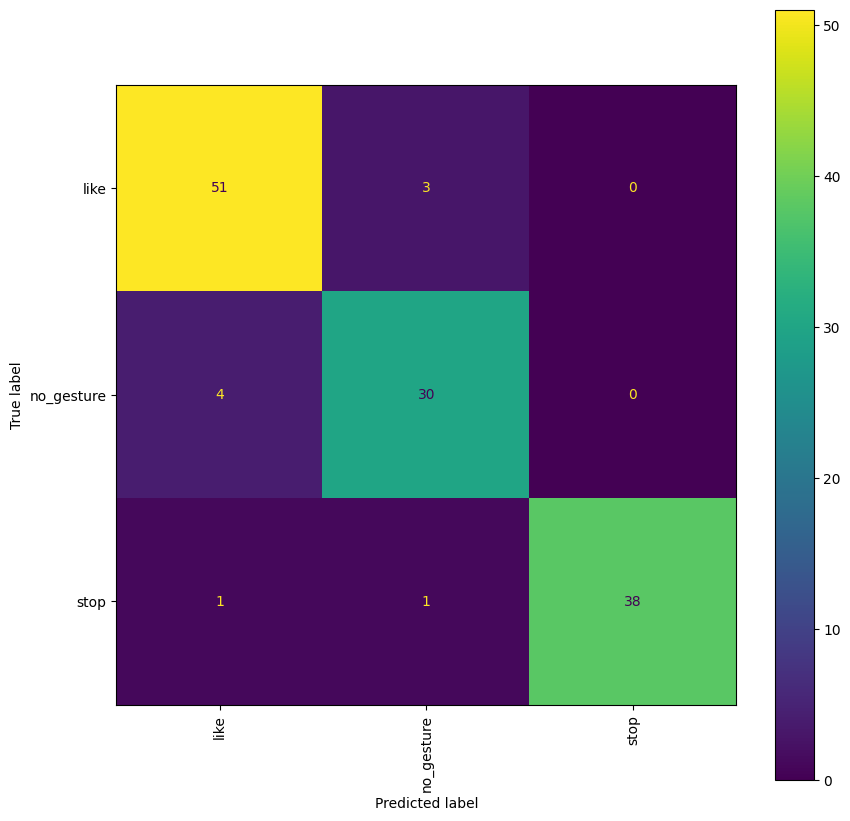

In [59]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# Summary

| Activation Function         | Time to Train Model (s)     | Epochs | Accuracy (%) |
|--------------|-----------|------------|------------|
| relu | 62.8 | 18 | 99.0 |
| sigmoid | 56.3 | 16 | 98.6 |
| tanh | 59.4 | 16 | 98.8 |
| linear | 41.7 | 11 | 96.9 |
| leaky relu | 66.0 | 11 | 99.2 |


As anticipated, the linear function outperformed exponential functions in terms of speed and the number of epochs required. However, the training time for ReLU and Leaky ReLU was the longest. In addition, ReLU required the highest number of epochs for training. This can be explained with the faster convergence of exponential functions. Nonetheless, ReLU and Leaky ReLU exhibited the highest accuracy, which can be attributed to the vanishing gradient problem commonly experienced with sigmoid and tanh activations. As expected, the linear activation function resulted poorer results due to the absence of backpropagation. The confusion matrix analysis revealed minimal differences, with approximately 8 false positives ±1.